1. Modeling of carbon cycle
In this problem, we will build a box model to understand the Earth’s carbon cycle based on the framework in Tomizuka 2009.

1.1 [15 points] Following equation 1-2 (without the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm (parts per million) from 1987 to 2004.

In [ ]:
我都是先用单位PgC去计算跑的模型,画图的时候转化为ppm画的图
求微分方程采用了两种方法，一种是显式欧拉法，另一种是python自带函数odeint，
试了一下后者效果更好（因为后者会自动选择适合的求解方式，所以精度会更高）

Method 1: 使用显式欧拉法来求解微分方程

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
# 参数
k12 = 105 / 740  # 大气到海洋的传输系数
k21 = 102 / 900  # 海洋到大气的传输系数
dt = 1  # 时间步长（年）

# 读取数据
file_path_co2 = 'co2_annmean_gl.csv'  # 海洋表面 CO2 数据（单位是ppm）
file_path_gamma = 'cleaned_gamma_data.csv'  # 排放数据 gamma（单位是ppm）
file_path_observed_atmos = 'co2_annmean_mlo.csv'  # 大气观测数据（单位是ppm）

data_ocean = pd.read_csv(file_path_co2)
data_gamma = pd.read_csv(file_path_gamma)
data_observed_atmos = pd.read_csv(file_path_observed_atmos)

# 筛选1987到2014年数据
data_ocean = data_ocean[(data_ocean['year'] >= 1986) & (data_ocean['year'] <= 2004)]
data_gamma = data_gamma[(data_gamma['Year'] >= 1986) & (data_gamma['Year'] <= 2004)]
data_observed_atmos = data_observed_atmos[(data_observed_atmos['year'] >= 1986) & (data_observed_atmos['year'] <= 2004)]

# 数据提取
years = data_ocean['year'].values
gamma_values = data_gamma['Total'].values/1000  #将单位从MtC/year转化为PgC/year
atmos_observed = data_observed_atmos['mean'].values

# 初始条件
N11 = [740]  # 初始大气 CO2 浓度
N21 = [900]  # 初始海洋表面 CO2 浓度

# 时间积分循环(跑模型的时候数据统一用的PgC/year为单位）
for t in range(1, len(years)):
    gamma = gamma_values[t]  # 当年的人为排放值
    
    # 计算 dN1/dt 和 dN2/dt
    dN1_dt = -k12 * N11[-1] + k21 * N21[-1] + gamma
    dN2_dt = k12 * N11[-1] - k21 * N21[-1]
    
    # 数值积分
    N1_new = N11[-1] + dN1_dt * dt
    N2_new = N21[-1] + dN2_dt * dt
    # 更新值
    N11.append(N1_new)
    N21.append(N2_new)
#画图的时候，将跑出来的预测数据单位换成了ppm
#1ppm=2.127PgC
N11 = np.array(N11) / 2.127
N21 = np.array(N21) / 2.127


Method 2: 用odeint函数自动选择方式来求解微分方程

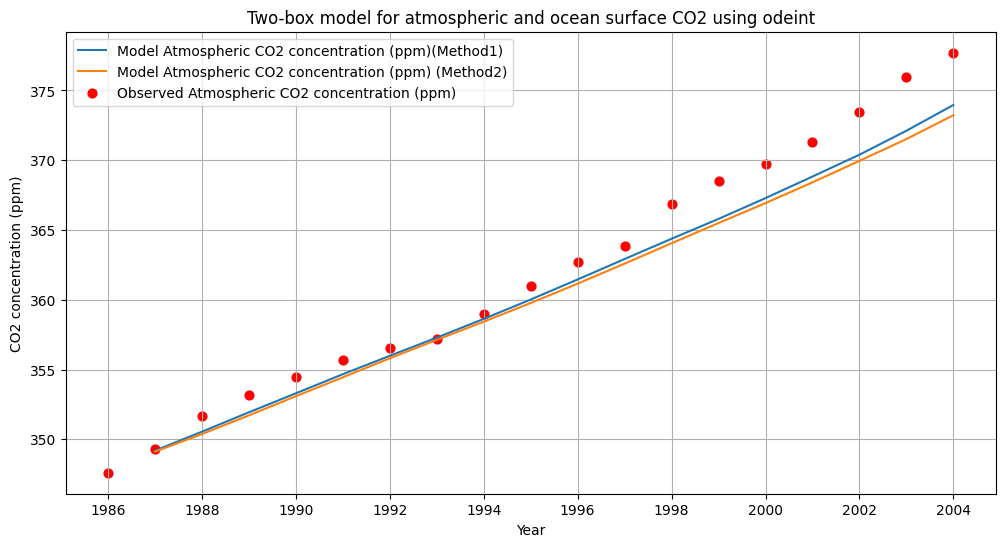

In [37]:
from scipy.integrate import odeint

# 参数
k12 = 105 / 740  # 大气到海洋的传输系数
k21 = 102 / 900  # 海洋到大气的传输系数
# 读取数据
file_path_gamma = 'cleaned_gamma_data.csv'  # 排放数据 gamma
file_path_observed_atmos = 'co2_annmean_mlo.csv'  # 大气观测数据

data_gamma = pd.read_csv(file_path_gamma)
data_observed_atmos = pd.read_csv(file_path_observed_atmos)

# 筛选1987到2004年数据
data_gamma = data_gamma[(data_gamma['Year'] >= 1986) & (data_gamma['Year'] <= 2004)]
data_observed_atmos = data_observed_atmos[(data_observed_atmos['year'] >= 1986) & (data_observed_atmos['year'] <= 2004)]

# 数据提取
years = data_gamma['Year'].values
# 转换为 单位
gamma_values = data_gamma['Total'].values / 1000  #将单位从MtC/year转化为PgC/year
atmos_observed = data_observed_atmos['mean'].values

# 初始条件
N1_0 = 740  # 初始大气 CO2 浓度（PgC）
N2_0 = 900  # 初始海洋表面 CO2 浓度（PgC）
initial_conditions = [N1_0, N2_0]

# 定义方程组
def two_box_model(y, t, gamma_values, k12, k21):
    N1, N2 = y  # 当前状态变量
    t_idx = int(t - years[0])  # 根据年份索引获取gamma值
    gamma = gamma_values[t_idx]  # 每年的gamma值
    dN1_dt = -k12 * N1 + k21 * N2 + gamma
    dN2_dt = k12 * N1 - k21 * N2
    return [dN1_dt, dN2_dt]

# 时间数组
t = years  # 每年的数据点

# 使用odeint求解
result = odeint(two_box_model, initial_conditions, t, args=(gamma_values, k12, k21))
# 恢复单位，除以2.127
#画图的时候，将跑出来的预测数据单位换成了ppm
#1ppm=2.127PgC
N1 = result[:, 0] / 2.127  
N2 = result[:, 1] / 2.127
# 绘图
plt.figure(figsize=(12, 6))

plt.plot(years[1:], N11[1:], label='Model Atmospheric CO2 concentration (ppm)(Method1) ')
plt.plot(years[1:], N1[1:], label='Model Atmospheric CO2 concentration (ppm) (Method2)')
plt.scatter(years, atmos_observed, label='Observed Atmospheric CO2 concentration (ppm)', color='red', marker='o', s=40)
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)')
plt.title('Two-box model for atmospheric and ocean surface CO2 using odeint')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()
plt.show()


1.2 [20 points] Following equation 3-4 (with the buffer effect), build a two-box model to compute the atmospheric CO2 level in ppm from 1987 to 2004.

In [ ]:
第二问文章中说：1959年至1979年观测到的大气中工业排放的比例大致保持在56%不变，
如果假定其余部分被海洋吸收，则相当于1986年工业排放总量44%的79 PgC可能会被添加到海洋表面。因此，令N2 = 900−79= 821。
所以在1.2中更改N2的初始值
至于N1的初始值，如果沿用上一题的740显然不合理，又找不到新的数据，请教了刘京朋同学，用了文章中图像里画的初始值，近似380×1.3=809.
用这两个初始值，画出了跟文章差不多的图。

Method 1: 使用显式欧拉法来求解微分方程

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
# 参数
k12 = 105 / 809  # 大气到海洋的传输系数
k21 = 102 / 821  # 海洋到大气的传输系数
N2_0 = 821  # 海洋表面平衡浓度
dt = 1  # 时间步长（年）

# 读取数据
file_path_co2 = 'co2_annmean_gl.csv'  # 海洋表面 CO2 数据
file_path_gamma = 'cleaned_gamma_data.csv'  # 排放数据 gamma
file_path_observed_atmos = 'co2_annmean_mlo.csv'  # 大气观测数据

data_ocean = pd.read_csv(file_path_co2)
data_gamma = pd.read_csv(file_path_gamma)
data_observed_atmos = pd.read_csv(file_path_observed_atmos)

# 筛选1987到2004年数据
data_ocean = data_ocean[(data_ocean['year'] >= 1986) & (data_ocean['year'] <= 2004)]
data_gamma = data_gamma[(data_gamma['Year'] >= 1986) & (data_gamma['Year'] <= 2004)]
data_observed_atmos = data_observed_atmos[(data_observed_atmos['year'] >= 1986) & (data_observed_atmos['year'] <= 2004)]

# 数据提取
years = data_ocean['year'].values
gamma_values = data_gamma['Total'].values / 1000  #将单位从MtC/year转化为PgC/year
atmos_observed = data_observed_atmos['mean'].values

# 初始条件
N1_buffer1 = [809]  # 初始大气 CO2 浓度
N2_buffer1 = [821]   # 初始海洋表面 CO2 浓度 

# 缓冲因子的函数
def buffer_factor(z):
    return 3.69 + 1.86e-2 * z - 1.80e-6 * z**2

# 时间积分循环
for t in range(1, len(years)):
    gamma = gamma_values[t]  # 当年的人为排放值
    # 动态计算缓冲因子 ξ(z)
    xi = buffer_factor(N1_buffer1[-1]/2.13)
    # 计算缓冲效应下的海洋表面 CO2 浓度修正项
    buffer_effect = N2_0 + xi * (N2_buffer1[-1] - N2_0)
    
    # 计算 dN1/dt 和 dN2/dt
    dN1_dt = -k12 * N1_buffer1[-1] + k21 * buffer_effect + gamma
    dN2_dt = k12 * N1_buffer1[-1] - k21 * buffer_effect

    # 数值积分
    N1_new = N1_buffer1[-1] + dN1_dt * dt
    N2_new = N2_buffer1[-1] + dN2_dt * dt

    # 更新值
    N1_buffer1.append(N1_new)
    N2_buffer1.append(N2_new)
N1_buffer1 = np.array(N1_buffer1) / 2.13
N2_buffer1 = np.array(N2_buffer1) / 2.13


Method 2: 用odeint函数自动选择方式来求解微分方程

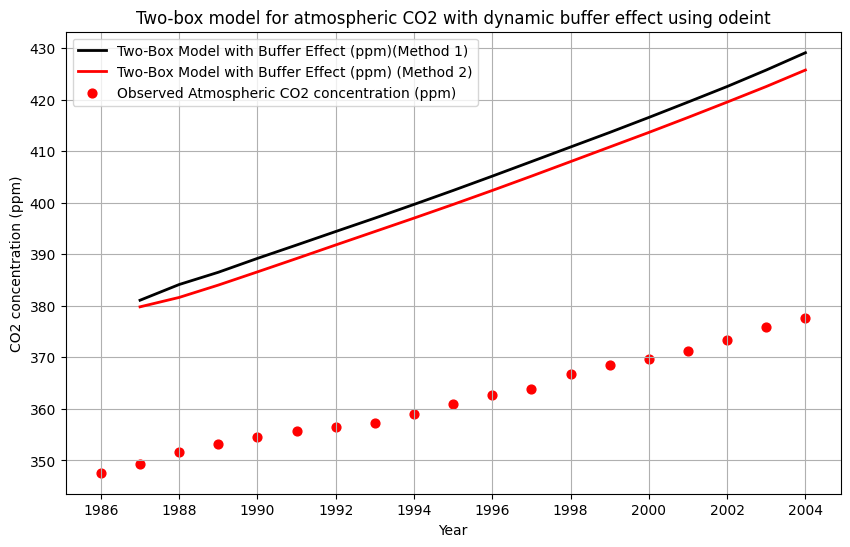

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import matplotlib.ticker as mticker

# 参数
k12 = 105 / 809  # 大气到海洋的传输系数
k21 = 102 / 821 # 海洋到大气的传输系数
N2_0 = 821  # 海洋表面平衡浓度

# 读取数据
file_path_gamma = 'cleaned_gamma_data.csv'  # 排放数据 gamma
file_path_observed_atmos = 'co2_annmean_mlo.csv'  # 大气观测数据

data_gamma = pd.read_csv(file_path_gamma)
data_observed_atmos = pd.read_csv(file_path_observed_atmos)

# 筛选1987到2004年数据
data_gamma = data_gamma[(data_gamma['Year'] >= 1987) & (data_gamma['Year'] <= 2004)]
data_observed_atmos = data_observed_atmos[(data_observed_atmos['year'] >= 1986) & (data_observed_atmos['year'] <= 2004)]
years_observed = data_observed_atmos['year'].values
# 数据提取
years = data_gamma['Year'].values
gamma_values = data_gamma['Total'].values / 1000  
atmos_observed = data_observed_atmos['mean'].values

# 初始条件
N1_0 = 809  # 初始大气 CO2 浓度（转换单位）
N2_0_converted = 821  # 初始海洋表面 CO2 浓度（转换单位）
initial_conditions = [N1_0, N2_0_converted]

# 缓冲因子的函数
def buffer_factor(z):
    """动态缓冲因子 ξ(z) 计算"""
    return 3.69 + 1.86e-2 * z - 1.80e-6 * z**2

# 定义方程组
def two_box_model(y, t, gamma_values, k12, k21, N2_0):
    N1, N2 = y  # 当前状态变量
    t_idx = int(t - years[0])  # 根据年份索引获取gamma值
    gamma = gamma_values[t_idx]  # 每年的gamma值
    
    # 计算动态缓冲因子
    xi = buffer_factor(N1/2.13)
    buffer_effect = N2_0 + xi * (N2 - N2_0)  # 缓冲效应
    
    # 定义微分方程
    dN1_dt = -k12 * N1 + k21 * buffer_effect + gamma
    dN2_dt = k12 * N1 - k21 * buffer_effect
    return [dN1_dt, dN2_dt]

# 时间数组
t = years  # 每年的数据点
# 使用odeint求解
result = odeint(two_box_model, initial_conditions, t, args=(gamma_values, k12, k21, N2_0))
# 提取结果并恢复单位
N1_buffer = result[:, 0] / 2.13  # 恢复单位
N2_buffer = result[:, 1] / 2.13

# 绘图
plt.figure(figsize=(10, 6))
plt.plot(t, N1_buffer1[1:], label='Two-Box Model with Buffer Effect (ppm)(Method 1)', color='black', linewidth=2)
plt.plot(t, N1_buffer, label='Two-Box Model with Buffer Effect (ppm) (Method 2)', color='red', linewidth=2)
plt.scatter(years_observed, atmos_observed, label='Observed Atmospheric CO2 concentration (ppm)', color='red', marker='o', s=40)
plt.xlabel('Year')
plt.ylabel('CO2 concentration (ppm)')
plt.title('Two-box model for atmospheric CO2 with dynamic buffer effect using odeint')
plt.gca().xaxis.set_major_locator(mticker.MaxNLocator(integer=True))
plt.legend()
plt.grid()
plt.show()


1.3 [5 points] Based on your results from 1.1 and 1.2, reproduce Figure 2 in Tomizuka (2009) as much as you can.

通过上述两种方法分析，我们可以看到Method 2: 用odeint函数自动选择方式来求解微分方程计算的结果更加接近论文中的Fig2，绘图结果如下

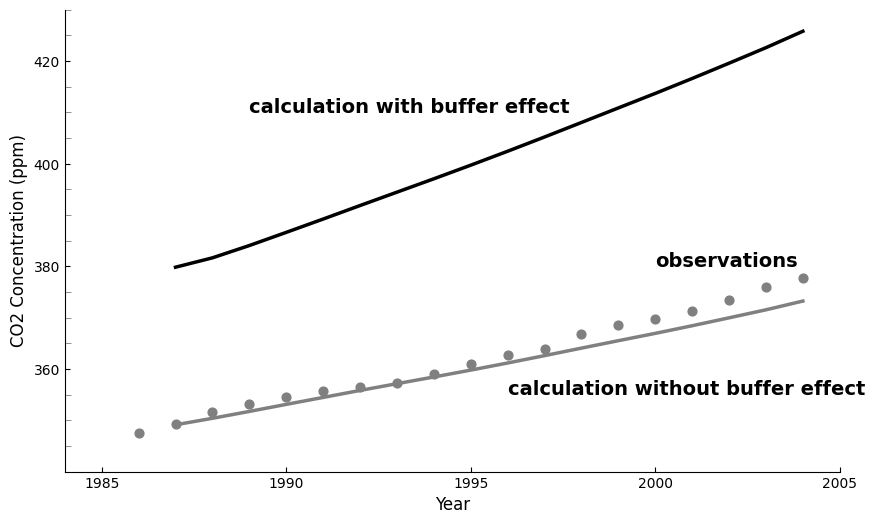

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.ticker import AutoMinorLocator
plt.figure(figsize=(10, 6))

# 绘制计算结果
plt.plot(years, N1_buffer, color='black', linewidth=2.5)
plt.plot(years, N1[1:], color='gray', linestyle='-', linewidth=2.5)

# 绘制观测数据
plt.scatter(years_observed, atmos_observed, color='gray', s=40, zorder=5)

# 添加手动文本标签（legend）
plt.text(1989, 410, 'calculation with buffer effect', fontsize=14, color='black', weight='bold')
plt.text(1996, 355, 'calculation without buffer effect', fontsize=14, color='black', weight='bold')
plt.text(2000, 380, 'observations', fontsize=14, color='black', weight='bold')

# 设置横纵坐标范围与刻度
plt.xlim(1984, 2005)
plt.ylim(340.0001, 430)

# 去掉右边和上边的坐标轴线
ax = plt.gca()
ax.spines['top'].set_visible(False)    # 去掉上边框线
ax.spines['right'].set_visible(False)  # 去掉右边框线

# 强制横纵坐标轴显示整数
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(5))  # 每5年显示一个刻度
plt.gca().yaxis.set_major_locator(mticker.MultipleLocator(20))  # 每20 ppm 显示一个主刻度

# 在Y轴中间添加三条次刻度线
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(4))  # 将每两个主刻度间分成4个区域（3个次刻度）
plt.tick_params(axis='both', which='both', direction='in')
# 设置次刻度线样式（不标注数值）
plt.tick_params(axis='y', which='minor', length=4, color='gray')  # 控制次刻度线的长度和颜色

# 设置标签和标题
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO2 Concentration (ppm)', fontsize=12)

# 显示图像
plt.show()


[Bonus] [10 points] Following equation 5-13, compute the atmospheric CO2 level in ppm and reproduce Figure 4 in Tomizuka (2009).

完成了β=0.38和β=0.50情况下七盒模型的仿真求解，并绘制出了Fig4


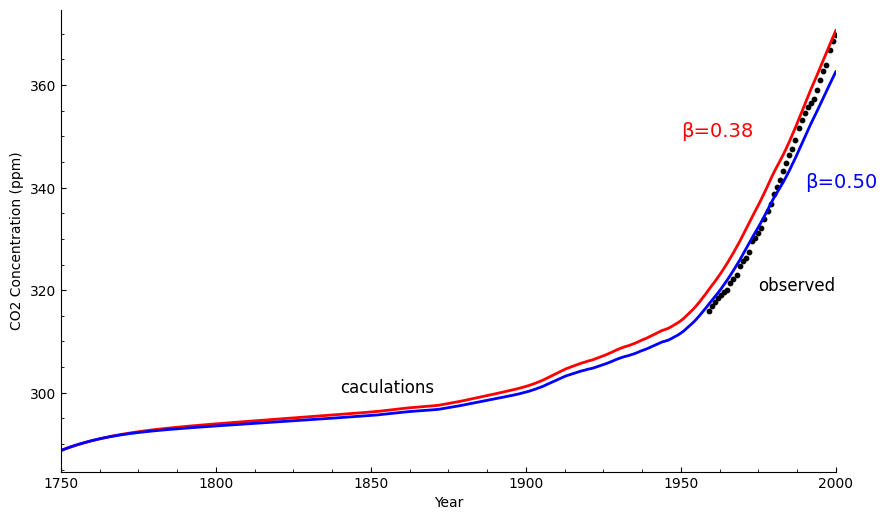

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from scipy.integrate import odeint

file_path_observed_atmos = 'co2_annmean_mlo.csv'  # 大气观测数据
data_observed_atmos = pd.read_csv(file_path_observed_atmos)
data_observed_atmos = data_observed_atmos[(data_observed_atmos['year'] <= 2000)]
atmos_observed = data_observed_atmos['mean'].values
years_observed = data_observed_atmos['year'].values
# 参数定义
N2_0 = 842  # 海洋表面平衡浓度

# 初始碳库浓度 (PgC)
N1_0, N2_0, N3_0, N4_0, N5_0, N6_0, N7_0 = 615, 842, 9744, 26280, 90000000, 731, 1328
initial_conditions = [N1_0, N2_0, N3_0, N4_0, N5_0, N6_0, N7_0]

# 传输系数 k_ij
k12, k21, k23, k24 = 60/615, 60/842, 9/842, 43/842
k32, k34, k43, k45 = 52/9744, 162/9744, 205/26280, 0.2/26280
k51, k67, k71 = 0.2/90000000, 62/731, 62/1328

# 读取人为排放 (gamma) 数据
gamma_data = pd.read_csv('cleaned_gamma_data.csv')
gamma_years = gamma_data['Year'].values
gamma_values = gamma_data['Total'].values / 1000  # 转换为 PgC/year

# 读取1850年之后的土地利用变化数据
land_use_data = pd.read_excel('Global_land-use_flux-1850_2005.xls')
land_use_years_later = land_use_data['Year'].values
land_use_emissions_later = land_use_data['Global'].values/1000

# 合并数据（1750到1850年是示例数据，1850年后的数据从文件读取）
land_use_years = np.arange(1750, 1850, 1)
land_use_emissions = np.linspace(0.2, 0.5, len(land_use_years))  # 示例数据

# 扩展土地利用排放数据
land_use_years_combined = np.concatenate([land_use_years, land_use_years_later])
land_use_emissions_combined = np.concatenate([land_use_emissions, land_use_emissions_later])

# 缓冲因子的函数
def buffer_factor(z):
    """动态缓冲因子 ξ(z) 计算"""
    return 3.69 + 1.86e-2 * z - 1.80e-6 * z**2

years = np.arange(1750, 2001, 1)  # 2000年结束
#求解 beta = 0.38时的模型
# NPP 函数
beta = 0.38  # CO2 敏感性参数
def npp(P, beta):
    """计算净初级生产力 (NPP)"""
    return 62 * (1 + beta * np.log(P / 290.21))

# 七箱模型方程
def seven_box_model_with_buffer(y, t):
    N1, N2, N3, N4, N5, N6, N7 = y
    year_index = int(t - 1750)  # 确定当前年份对应的索引
    gamma = gamma_values[year_index] if year_index < len(gamma_values) else gamma_values[-1]
    delta = land_use_emissions_combined[year_index] if year_index < len(land_use_emissions_combined) else land_use_emissions_combined[-1]
    xi = buffer_factor(N1 / 2.13)  # 计算缓冲因子
    f = npp(N1 / 2.13, beta)  # 计算 NPP

    # 带缓冲效应的海洋碳交换
    buffer_effect = k21 * (N2_0 + xi * (N2 - N2_0))

    # 七箱模型方程
    dN1_dt = -k12 * N1 + buffer_effect + delta + gamma - f + k51 * N5+ k71 * N7
    dN2_dt = k12 * N1 - buffer_effect - k23 * N2 + k32 * N3 - k24 * N2
    dN3_dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
    dN4_dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
    dN5_dt = k45 * N4 - k51 * N5
    dN6_dt = f - k67 * N6 - 2 * delta
    dN7_dt = k67 * N6 - k71 * N7 + delta

    return [dN1_dt, dN2_dt, dN3_dt, dN4_dt, dN5_dt, dN6_dt, dN7_dt]

solution = odeint(seven_box_model_with_buffer, initial_conditions, years)
#求解beta = 0.50时的模型
beta = 0.50  # CO2 敏感性参数
def npp(P, beta):
    """计算净初级生产力 (NPP)"""
    return 62 * (1 + beta * np.log(P / 290.21))

# 七箱模型方程
def seven_box_model_with_buffer(y, t):
    N1, N2, N3, N4, N5, N6, N7 = y
    year_index = int(t - 1750)  # 确定当前年份对应的索引
    gamma = gamma_values[year_index] if year_index < len(gamma_values) else gamma_values[-1]
    delta = land_use_emissions_combined[year_index] if year_index < len(land_use_emissions_combined) else land_use_emissions_combined[-1]
    xi = buffer_factor(N1 / 2.13)  # 计算缓冲因子
    f = npp(N1 / 2.13, beta)  # 计算 NPP

    # 带缓冲效应的海洋碳交换
    buffer_effect = k21 * (N2_0 + xi * (N2 - N2_0))

    # 七箱模型方程
    dN1_dt = -k12 * N1 + buffer_effect + delta + gamma - f + k51 * N5+ k71 * N7
    dN2_dt = k12 * N1 - buffer_effect - k23 * N2 + k32 * N3 - k24 * N2
    dN3_dt = k23 * N2 - k32 * N3 - k34 * N3 + k43 * N4
    dN4_dt = k34 * N3 - k43 * N4 + k24 * N2 - k45 * N4
    dN5_dt = k45 * N4 - k51 * N5
    dN6_dt = f - k67 * N6 - 2 * delta
    dN7_dt = k67 * N6 - k71 * N7 + delta

    return [dN1_dt, dN2_dt, dN3_dt, dN4_dt, dN5_dt, dN6_dt, dN7_dt]

# 求解模型
solution1 = odeint(seven_box_model_with_buffer, initial_conditions, years)
# 提取大气 CO2 浓度结果
N1_ppm = solution[:, 0] / 2.13  # 大气 CO2 浓度 (ppm)
N1_ppm1 = solution1[:, 0] / 2.13  # 大气 CO2 浓度 (ppm)
# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(years, N1_ppm, label='Atmospheric CO2 (ppm)', color='red', linewidth=2)
plt.plot(years, N1_ppm1, label='Atmospheric CO2 (ppm)', color='blue', linewidth=2)
plt.scatter(years_observed, atmos_observed, label='Atmospheric CO2 (ppm)', color='black',s=10)
plt.xlabel('Year')
plt.ylabel('CO2 Concentration (ppm)')
plt.gca().xaxis.set_major_locator(MultipleLocator(50))  # 每50年显示一次
plt.gca().yaxis.set_minor_locator(AutoMinorLocator(4))
plt.gca().xaxis.set_minor_locator(AutoMinorLocator(4))
plt.tick_params(axis='both', which='both', direction='in')
plt.xlim(280, 400)
plt.xlim(1750, 2000)
ax = plt.gca()
ax.spines['top'].set_visible(False)    # 去掉上边框线
ax.spines['right'].set_visible(False)  # 去掉右边框线
# 添加手动文本标签（legend）
plt.text(1950, 350, 'β=0.38', fontsize=14, color='red')
plt.text(1990, 340, 'β=0.50', fontsize=14, color='blue')
plt.text(1840, 300, 'caculations', fontsize=12, color='black')
plt.text(1975, 320, 'observed', fontsize=12, color='black')
plt.show()

1.数据网站打不开，是找朋友的朋友在美国给下载下来的，怀疑是直接卡定位了
2.数据没有下载全所以fig4有点残缺，缺少从1750年开始的观测值

In [ ]:
终于写完最后一次python作业了！！！！（每次作业都要写一个周）
感谢助教每次的耐心批改！！！!感谢朱雷老师的指导！不感谢南方英语pre大学！感谢我所有会写代码的朋友！最最重要的是感谢chatgpt4o老师！
